# Visualize Labeled ARCS Data
This notebook is just used to look at different datasets and labels

In [202]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json

In [203]:
show_bbox = True
show_label_area = False

## Choose five frames

In [250]:
# frames = ['001351', '005940', '003242', '004679', '003849']
# frames = ['005940', '005940', '003242', '004679', '003849']
frames = ['005940', '000103', '003242', '004679', '003849']

# bin_path_0 = f'..\\..\\data\\test_folder\\{frames[0]}.bin'
# bin_path_0 = '..\\..\\..\\kitti_stationary\\stationary_data\\2011_09_26_drive_0018_sync_0_to_178\\filtered_points\\0000000014.bin'
# D:\arcs\data\calibration_test\extracted_frames
bin_path_0 = f'..\\..\\data\\calibration_test\\extracted_frames\\frame_30_960678.bin'
points_0 = np.fromfile(bin_path_0, dtype=np.float32).reshape(-1, 4)
print(len(points_0))
labels_0 = f'..\\..\\data\\pillar_pred_format_labels\\{frames[0]}.txt'

# bin_path_1 = f'..\\..\\data\\test_folder\\{frames[1]}.bin'
bin_path_1 = f'..\\..\\data\\velodyne_points\\{frames[1]}.bin'
points_1 = np.fromfile(bin_path_1, dtype=np.float32).reshape(-1, 4)
labels_1 = f'..\\..\\data\\pillar_pred_format_labels\\{frames[1]}.txt'

bin_path_2 = f'..\\..\\data\\test_folder\\{frames[2]}.bin'
points_2 = np.fromfile(bin_path_2, dtype=np.float32).reshape(-1, 4)
labels_2 = f'..\\..\\data\\pillar_pred_format_labels\\{frames[2]}.txt'

bin_path_3 = f'..\\..\\data\\test_folder\\{frames[3]}.bin'
points_3 = np.fromfile(bin_path_3, dtype=np.float32).reshape(-1, 4)
labels_3 = f'..\\..\\data\\pillar_pred_format_labels\\{frames[3]}.txt'

bin_path_4 = f'..\\..\\data\\test_folder\\{frames[4]}.bin'
points_4 = np.fromfile(bin_path_4, dtype=np.float32).reshape(-1, 4)
labels_4 = f'..\\..\\data\\pillar_pred_format_labels\\{frames[4]}.txt'

# And the actual kitti data
bin_path_4 = '..\\..\\..\\kitti\\training\\velodyne\\000056.bin'
points_4 = np.fromfile(bin_path_4, dtype=np.float32).reshape(-1, 4)
labels_4 = '..\\..\\..\\kitti\\training\\label_2\\000056.txt'

64


## Visualization functions

Interesting. So right off the bat, my function is plotting the bounding boxes in a different spot that the point clouds (I'm working with lidar). I think this is because of how the previous person converted the data from the labeler. I'm not sure if I should change all the labels so they are formatted better, but first, I want to see if I can just visualize them correctly. 

In [208]:
# Function to plot the bounding box
def plot_bbox(ax, bbox):
    # Bounding box order that displays pointpillars predictions correctly   
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color='r', linewidth=1)

In [209]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [210]:
def set_axes_limited(ax, limit=200):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [211]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
    return np.array(bboxes)

In [212]:
print(read_kitti_labels(labels_0))

[[ 8.16 21.53 -0.8   2.11  4.98  2.31  3.66]
 [14.75 10.64 -0.22  1.75  4.55  2.63  3.66]
 [ 2.16 25.83 -1.4   2.46  5.19  2.55  0.53]]


ARCS label area is: [-51.955, 26.035, -16.25, 39.684999999999995, -4.16, 3.375]

In [214]:
# Center (x, y, z): (-12.959999999999999, 11.717499999999998, -0.39250000000000007)
# Dimensions (l, w, h): (77.99, 55.934999999999995, 7.535)
# label_area = 7.535, 55.934999999999995, 77.99, -12.959999999999999, -0.39250000000000007, 11.717499999999998, 0
label_area = 7.535, 55.934999999999995, 77.99, -12.959999999999999, -0.39250000000000007, 11.717499999999998, 0

In [215]:
# Adjusted label area
# Center (x, y, z): (13.0175, 11.717499999999998, -0.39250000000000007)
# Dimensions (l, w, h): (26.035, 55.934999999999995, 7.535)
# label_area = 7.535, 55.934999999999995, 26.035, 13.0175, -0.39250000000000007, 11.717499999999998, 0
label_area = 7.535, 55.934999999999995, 77.99, -12.959999999999999, -0.39250000000000007, 11.717499999999998, 0


In [216]:
# Function to plot the bounding box
def add_label_area(ax):
    # Define the point cloud range
    x_range = [-51.955, 39.684999999999995]
    # x_range = [0, 39.684999999999995]
    y_range = [26.035, -4.16]
    z_range = [-16.25, 3.375]
    
    # Plotting the corners of the cuboid
    for x in x_range:
        for y in y_range:
            for z in z_range:
                ax.scatter(x, y, z, color='b')
    
    # Connect the points to form the edges of the cuboid
    for x in x_range:
        ax.plot([x, x], y_range, [z_range[0], z_range[0]], 'r')
        ax.plot([x, x], y_range, [z_range[1], z_range[1]], 'r')
        ax.plot([x, x], [y_range[0], y_range[0]], z_range, 'r')
        ax.plot([x, x], [y_range[1], y_range[1]], z_range, 'r')
    
    for y in y_range:
        ax.plot(x_range, [y, y], [z_range[0], z_range[0]], 'r')
        ax.plot(x_range, [y, y], [z_range[1], z_range[1]], 'r')
    
    for z in z_range:
        ax.plot(x_range, [y_range[0], y_range[0]], [z, z], 'r')
        ax.plot(x_range, [y_range[1], y_range[1]], [z, z], 'r')
        ax.plot([x_range[0], x_range[0]], y_range, [z, z], 'r')
        ax.plot([x_range[1], x_range[1]], y_range, [z, z], 'r')


In [217]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_0[:, 0], points_0[:, 1], points_0[:, 2], s=0.8, c=points_0[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
# if show_bbox:
#     for bbox in read_kitti_labels(labels_0):
#         plot_bbox(ax, bbox)
#         print(bbox)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=30, azim=230) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)
set_axes_limited(ax)


plt.show()


# Save the figure
# fig.savefig('3d_scatter_with_bboxes_0.png', dpi=300)

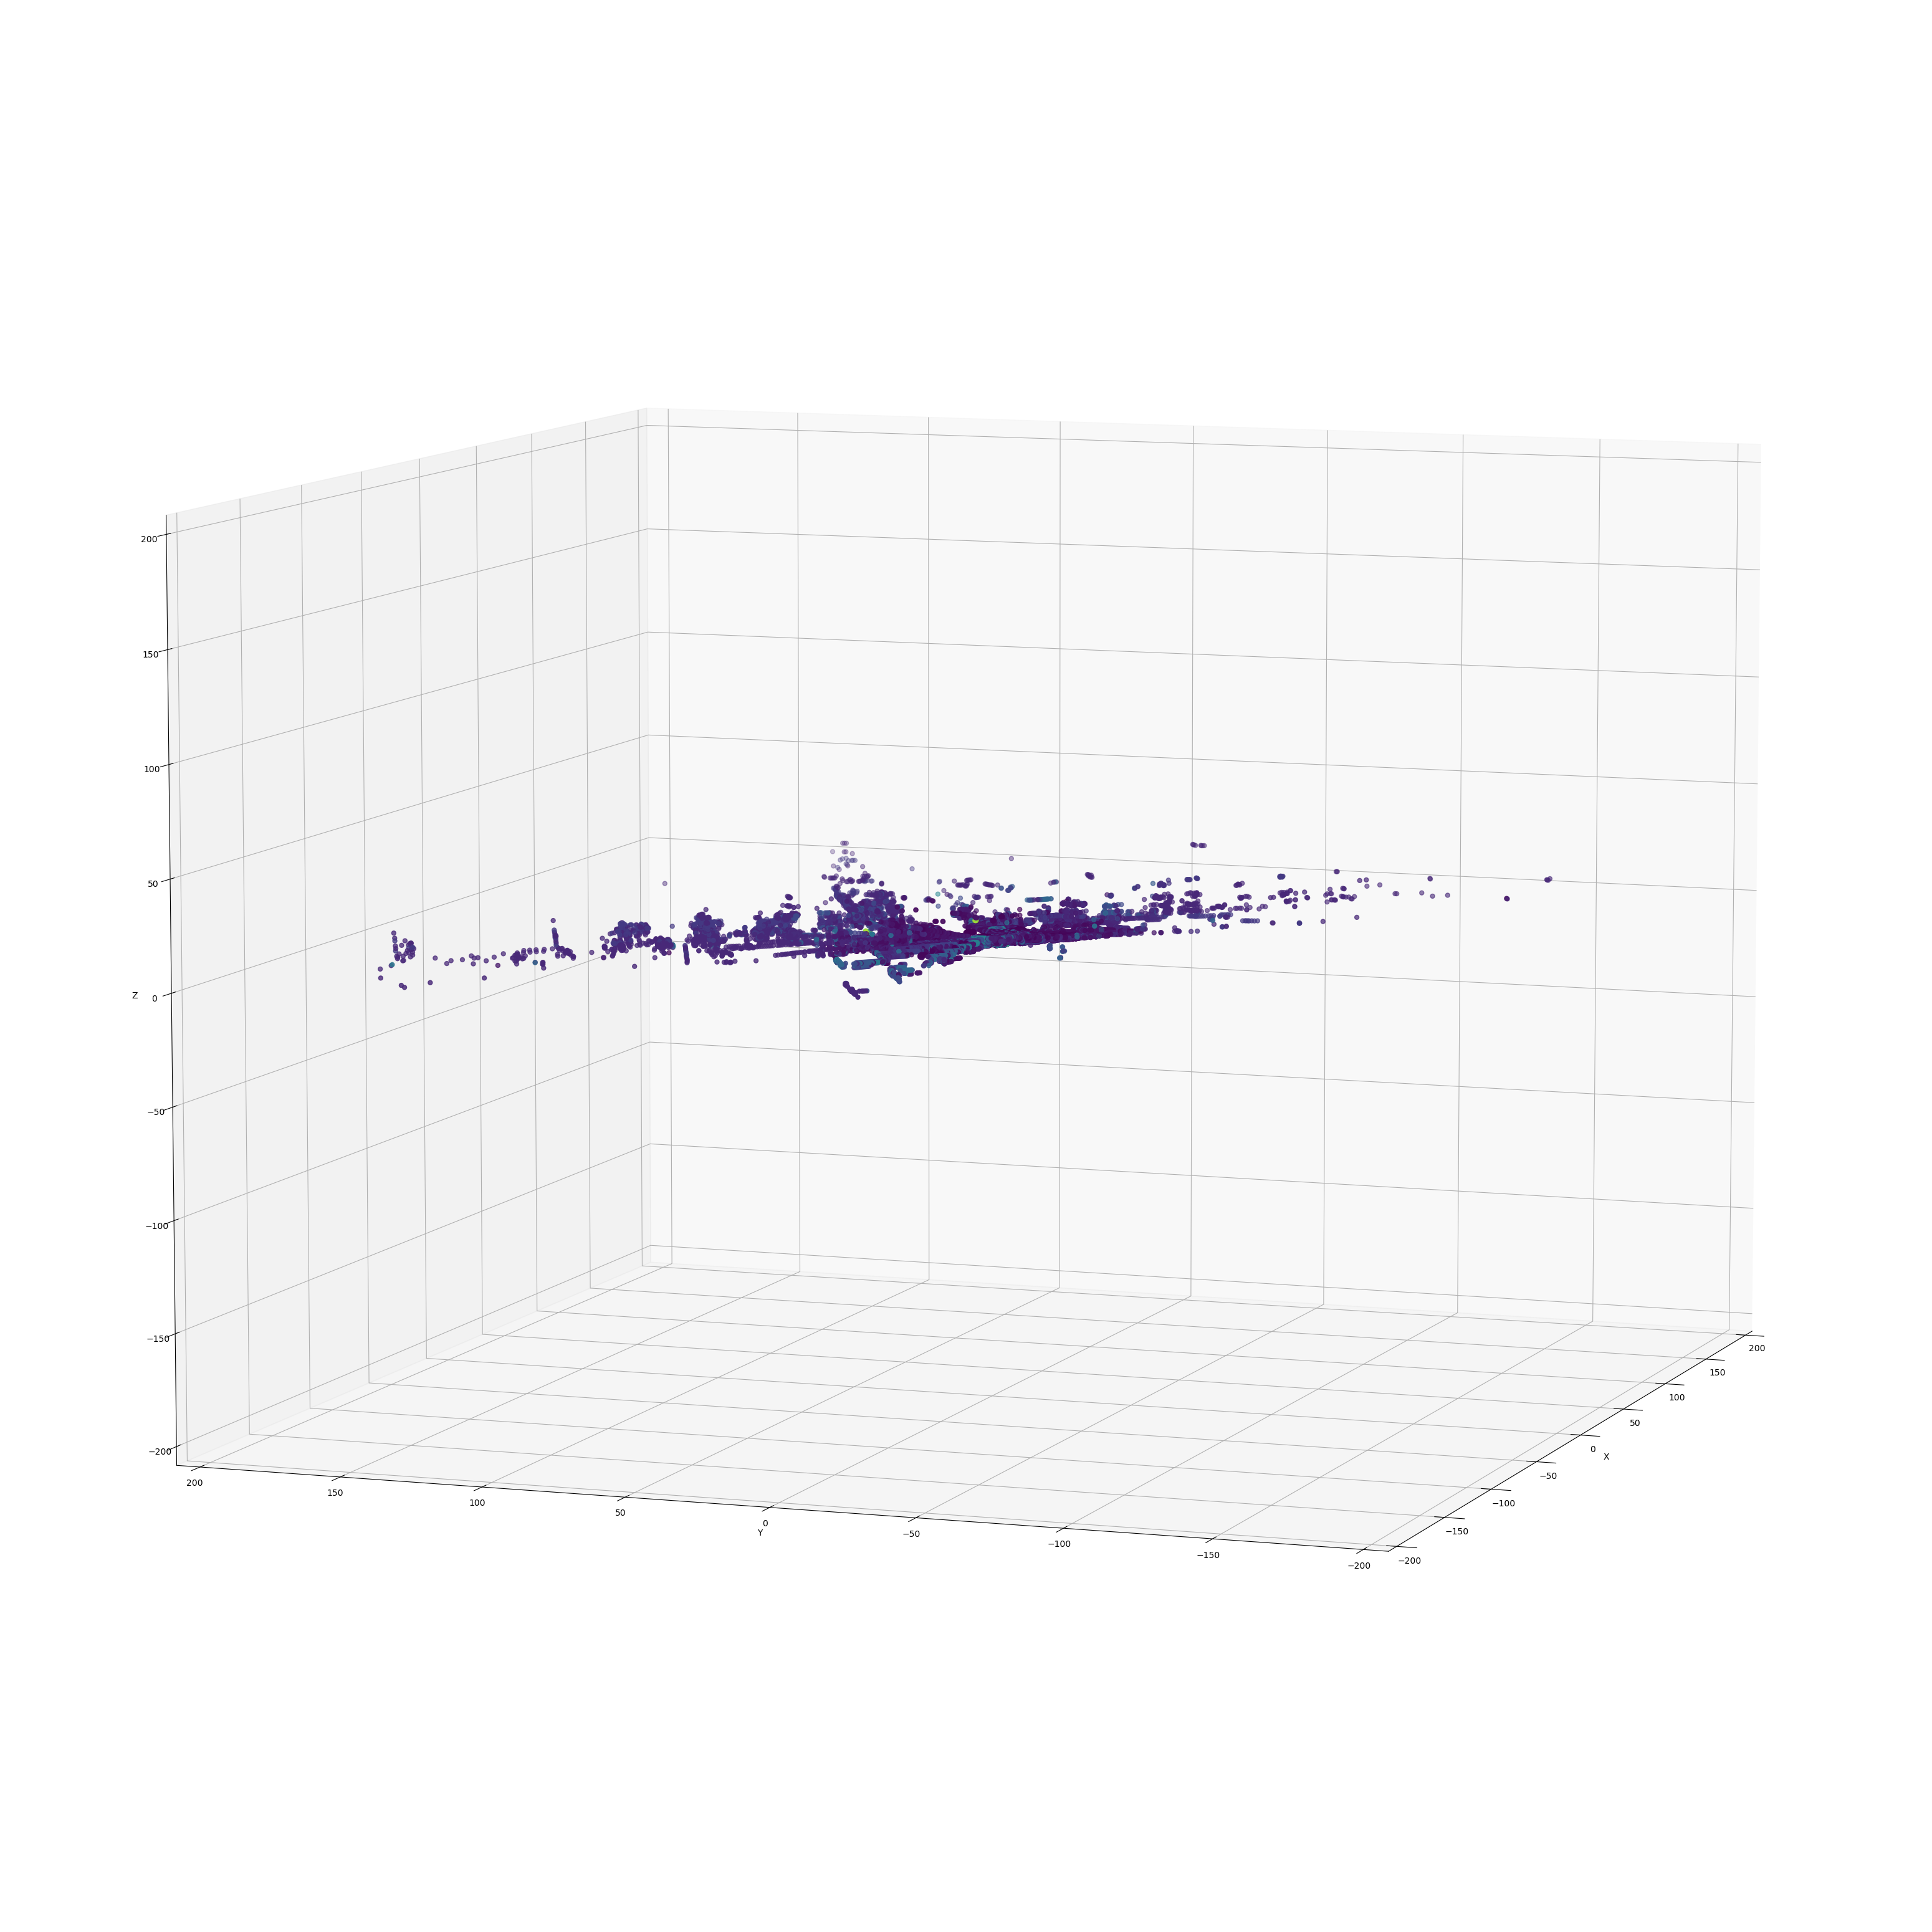

In [218]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
# ax.scatter(points_1[:, 0], points_1[:, 1], points_1[:, 2], s=10 * (points_1[:, 0] + points_1[:, 1] + points_1[:, 2]), c=points_1[:, 3], cmap='viridis', marker='.')
ax.scatter(points_1[:, 0], points_1[:, 1], points_1[:, 2], s=100, c=points_1[:, 3], cmap='viridis', marker='.')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
# if show_bbox:
#     for bbox in read_kitti_labels(labels_1):
#         plot_bbox(ax, bbox)

# if show_label_area:
#     plot_bbox(ax, label_area)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=8, azim=200)
# ax.view_init(elev=45, azim=190)

# Fix aspect ratio
set_axes_equal(ax)
set_axes_limited(ax)


plt.show()


# Save the figure
fig.savefig('3d_scatter_with_bboxes_1.png', dpi=300)

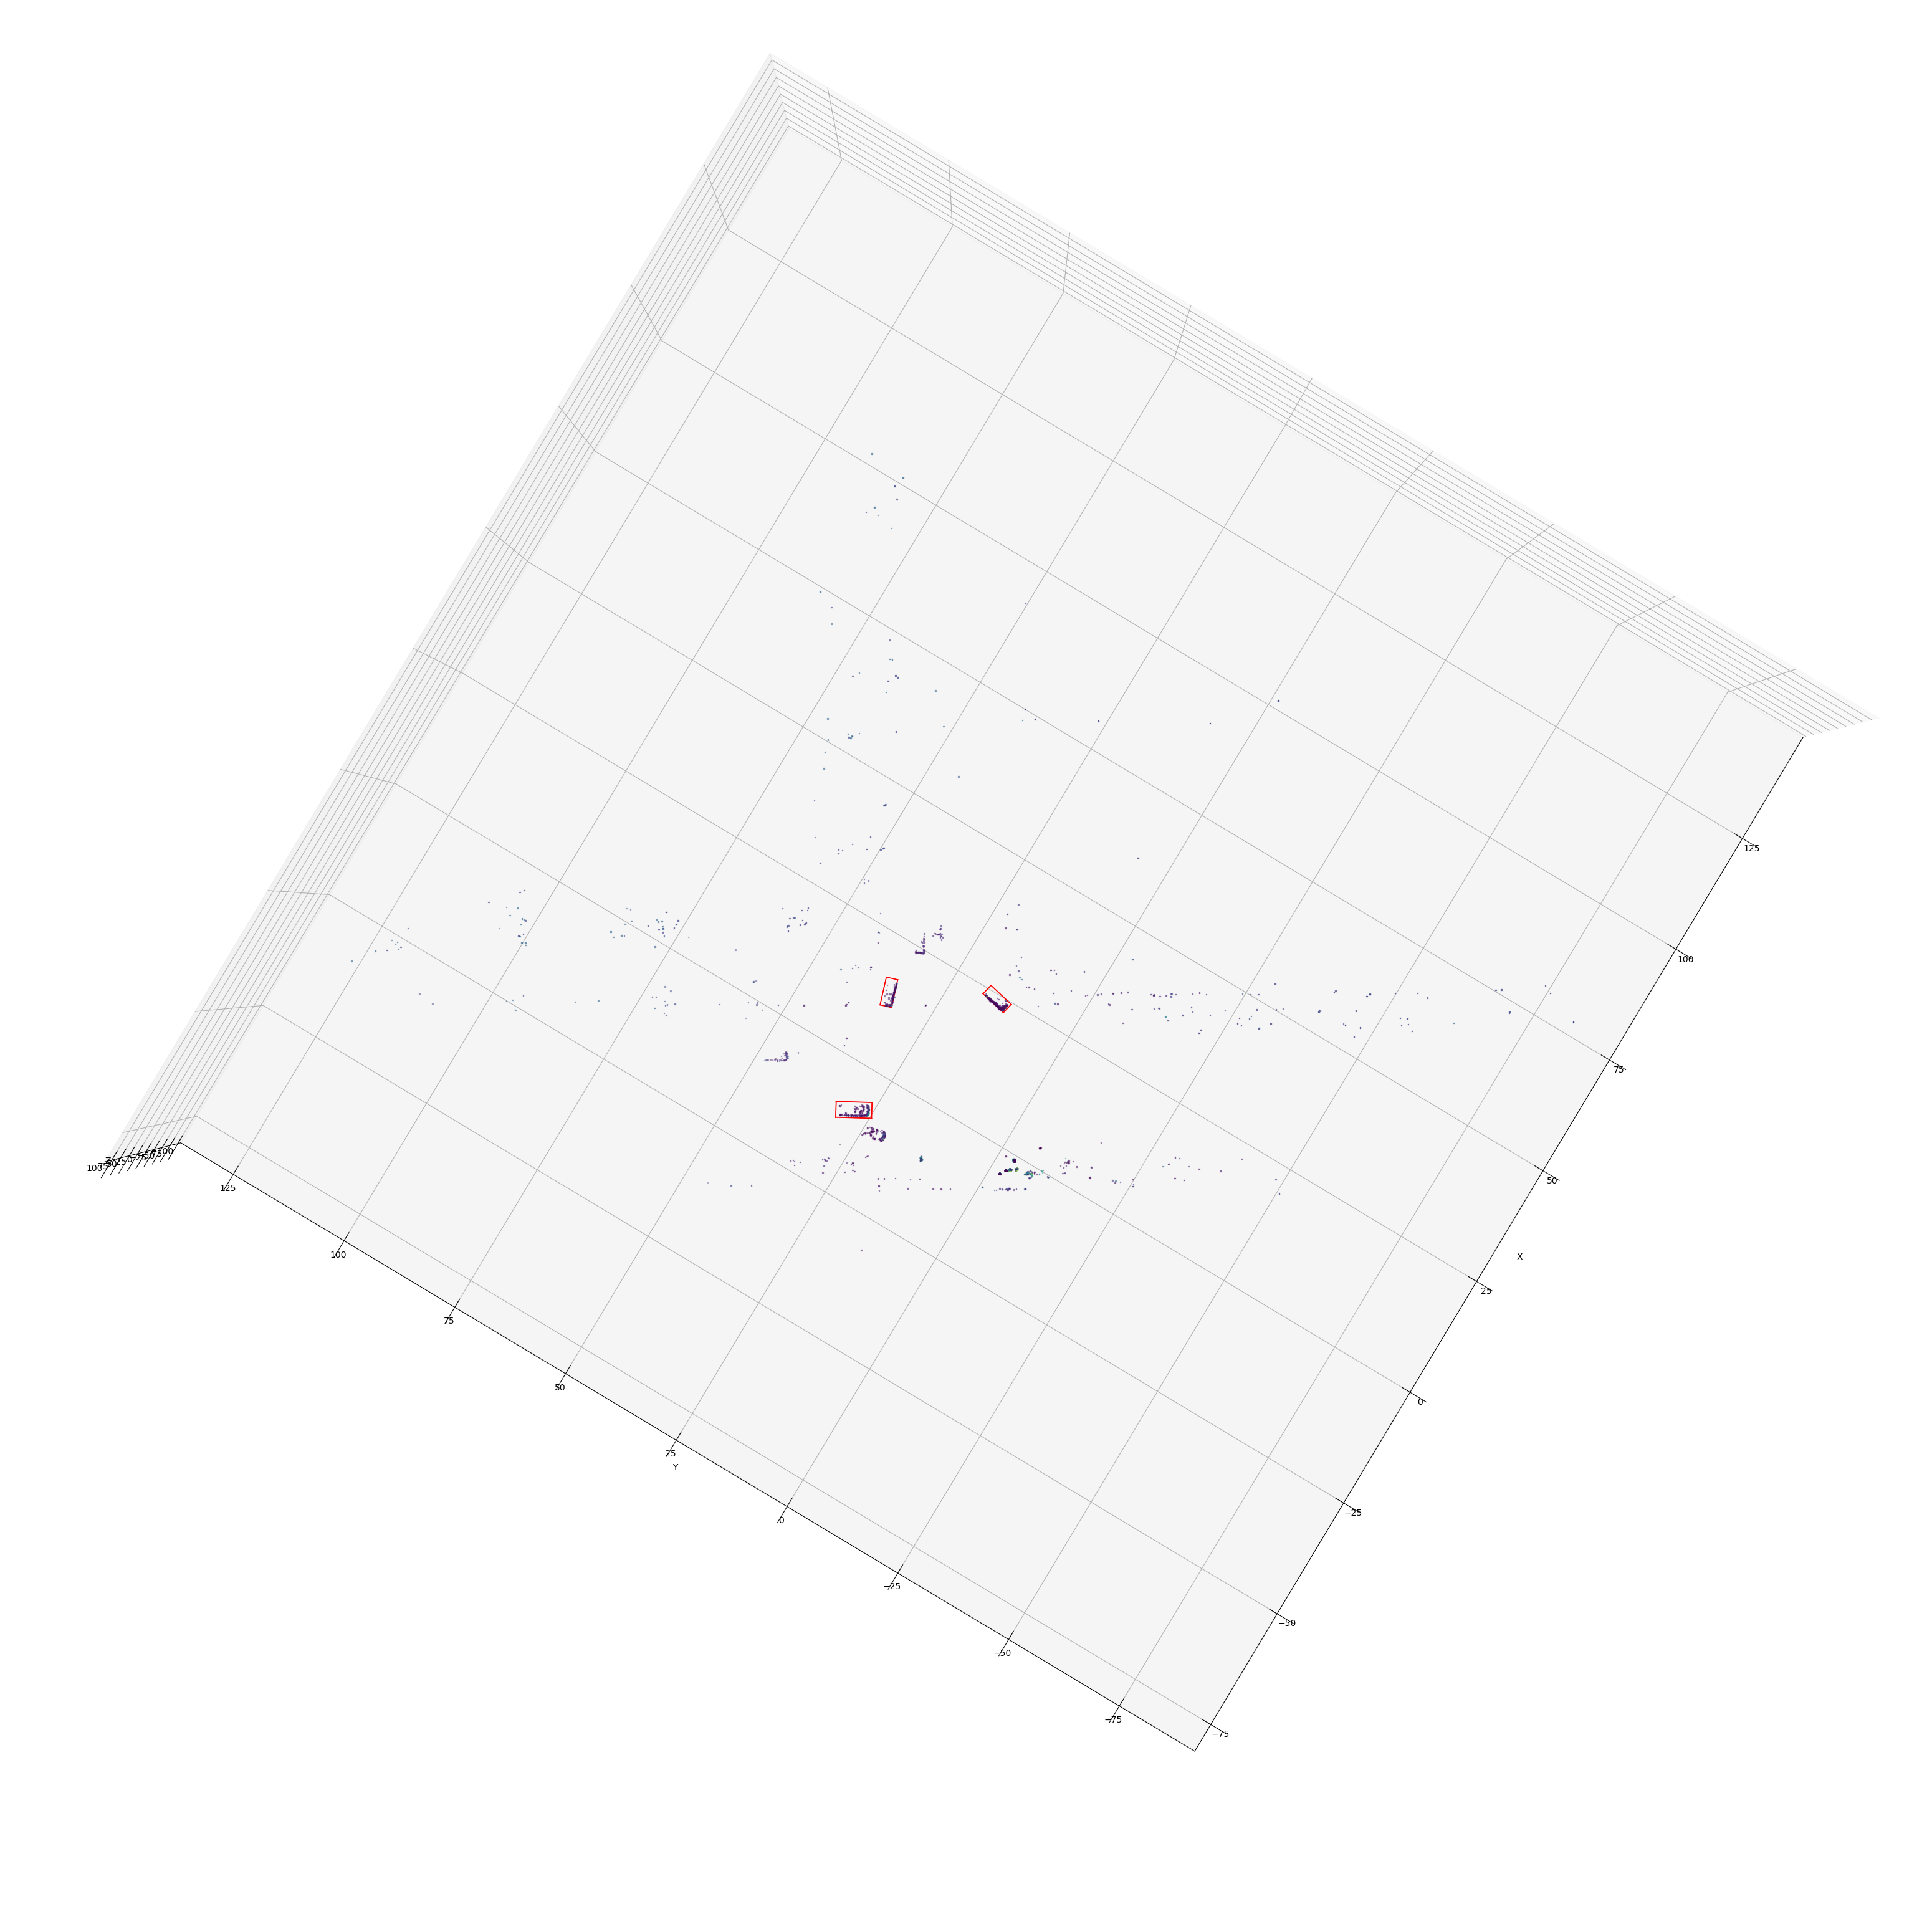

In [219]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_2[:, 0], points_2[:, 1], points_2[:, 2], s=1, c=points_2[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
if show_bbox:
    for bbox in read_kitti_labels(labels_2):
        plot_bbox(ax, bbox)

if show_label_area:
    plot_bbox(ax, label_area)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

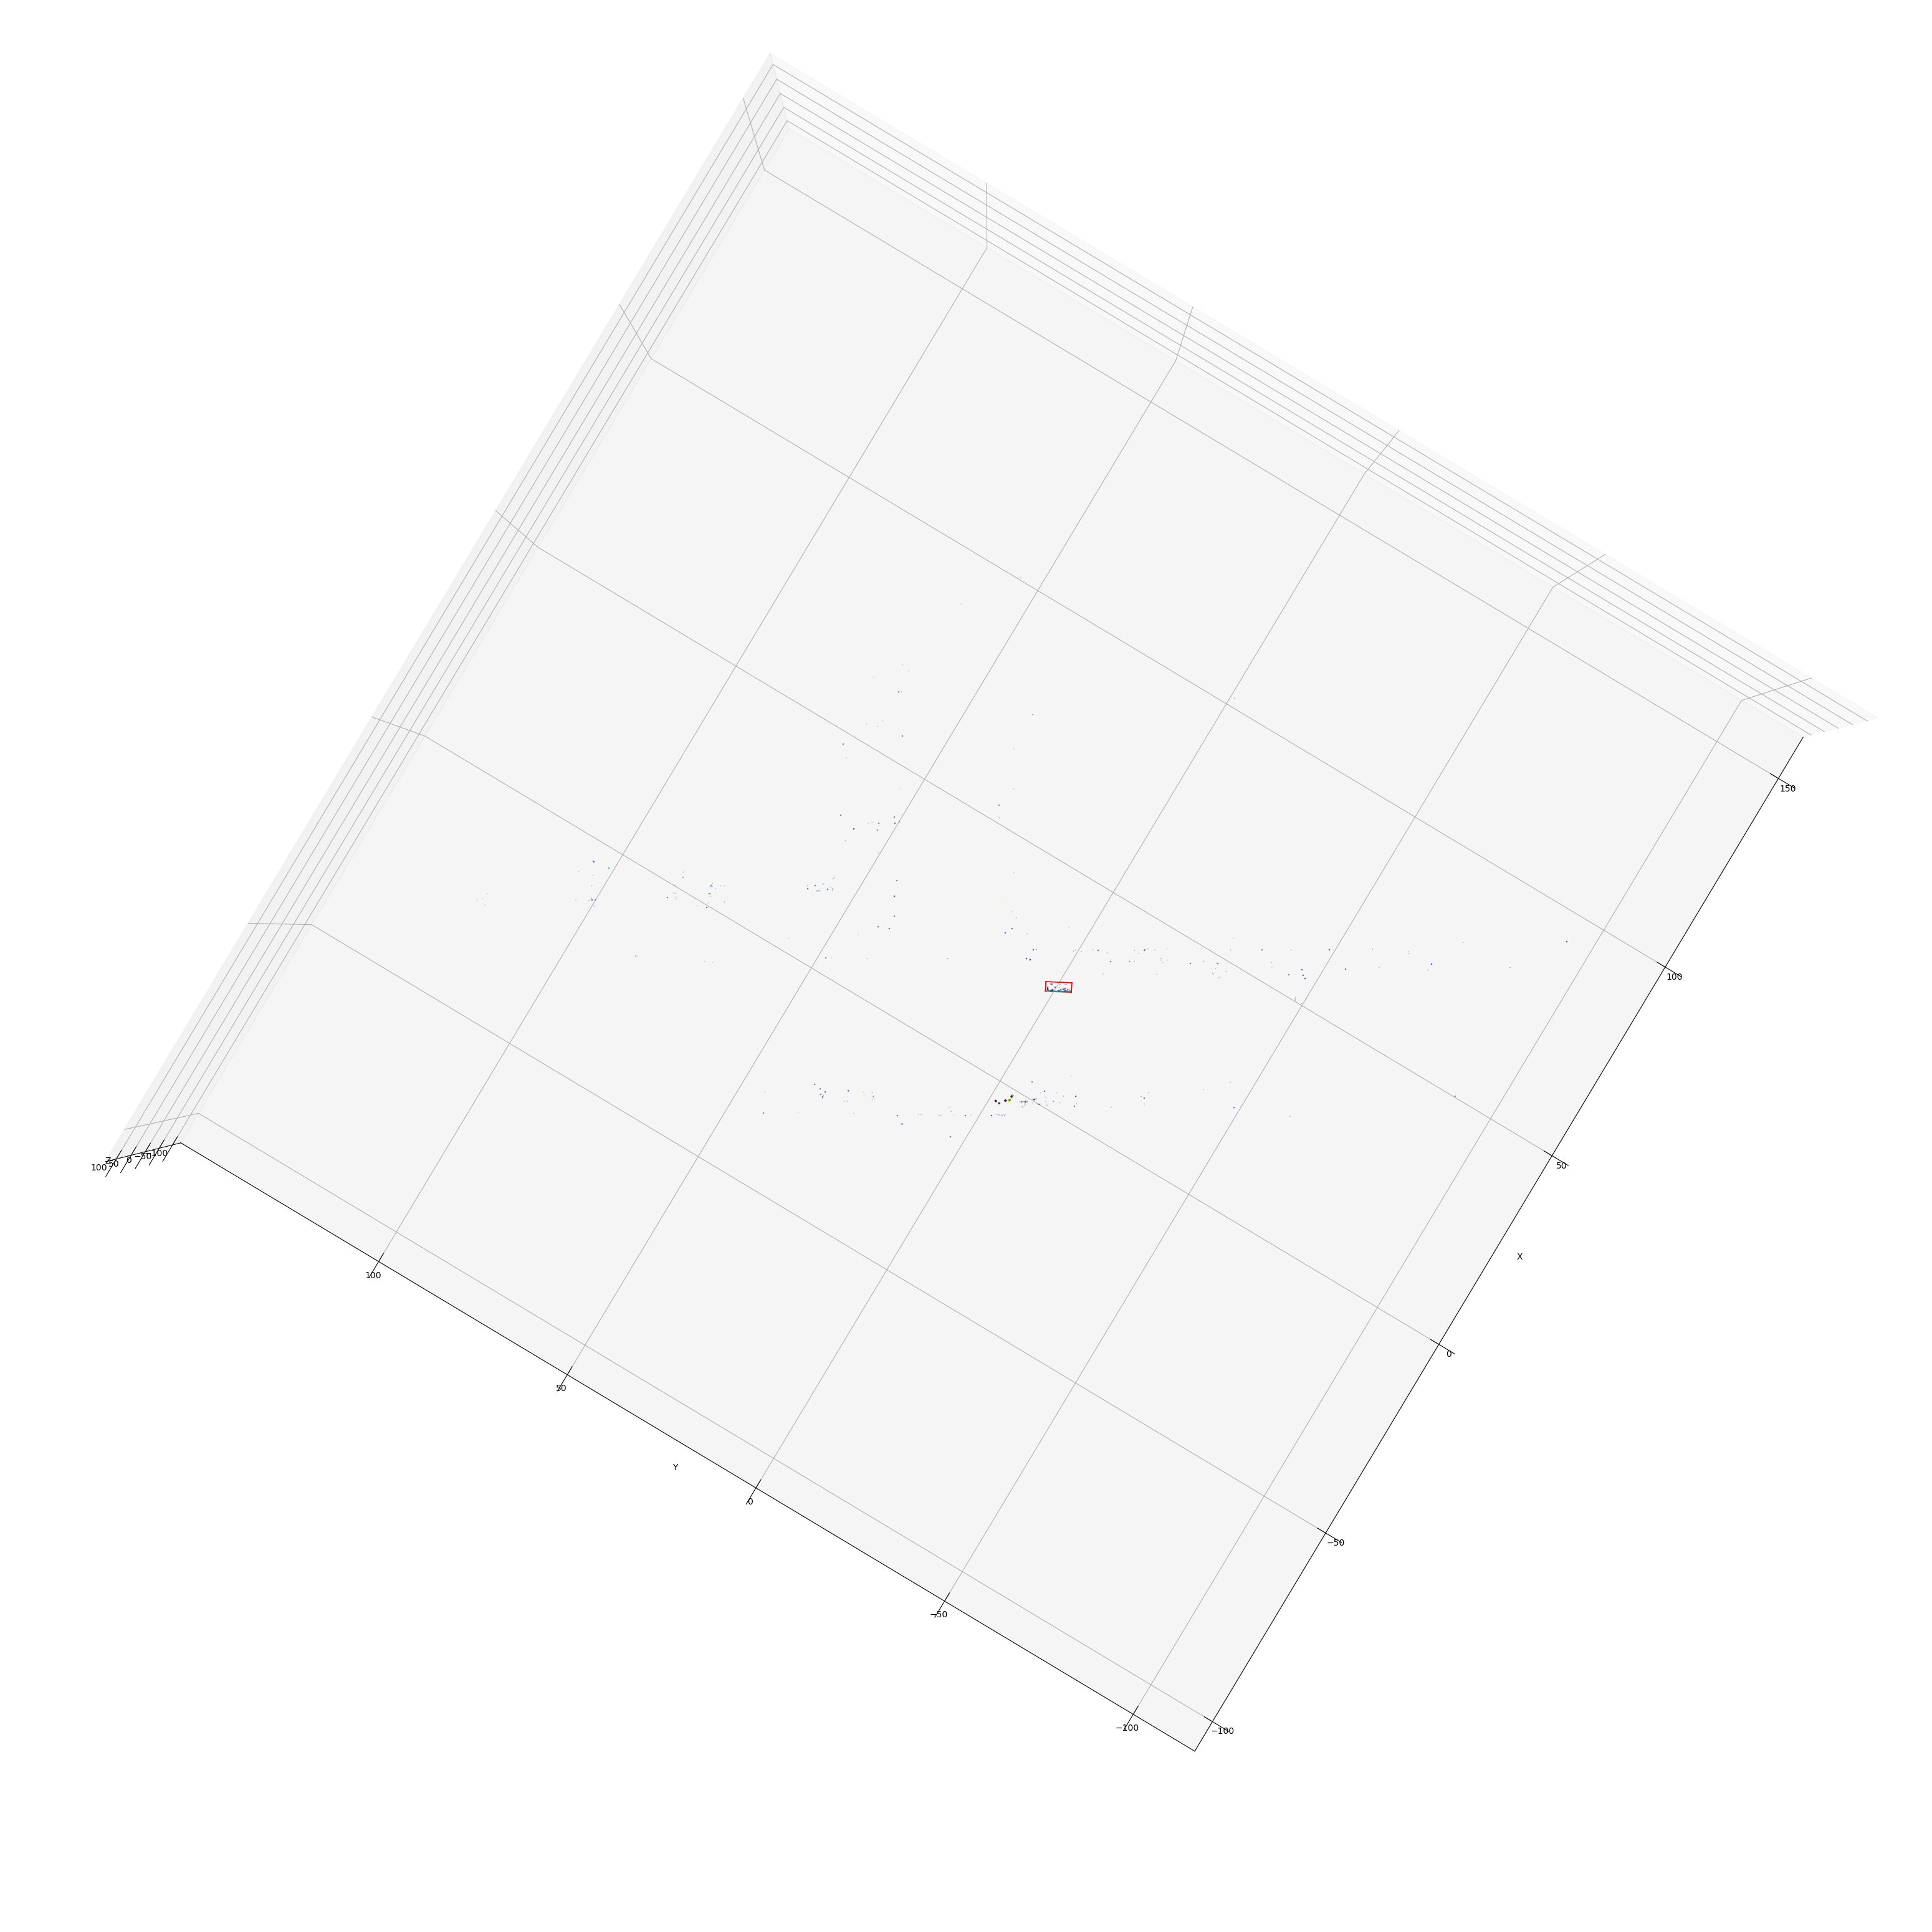

In [220]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_3[:, 0], points_3[:, 1], points_3[:, 2], s=0.1, c=points_3[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
if show_bbox:
    for bbox in read_kitti_labels(labels_3):
        plot_bbox(ax, bbox)

if show_label_area:
    plot_bbox(ax, label_area)

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

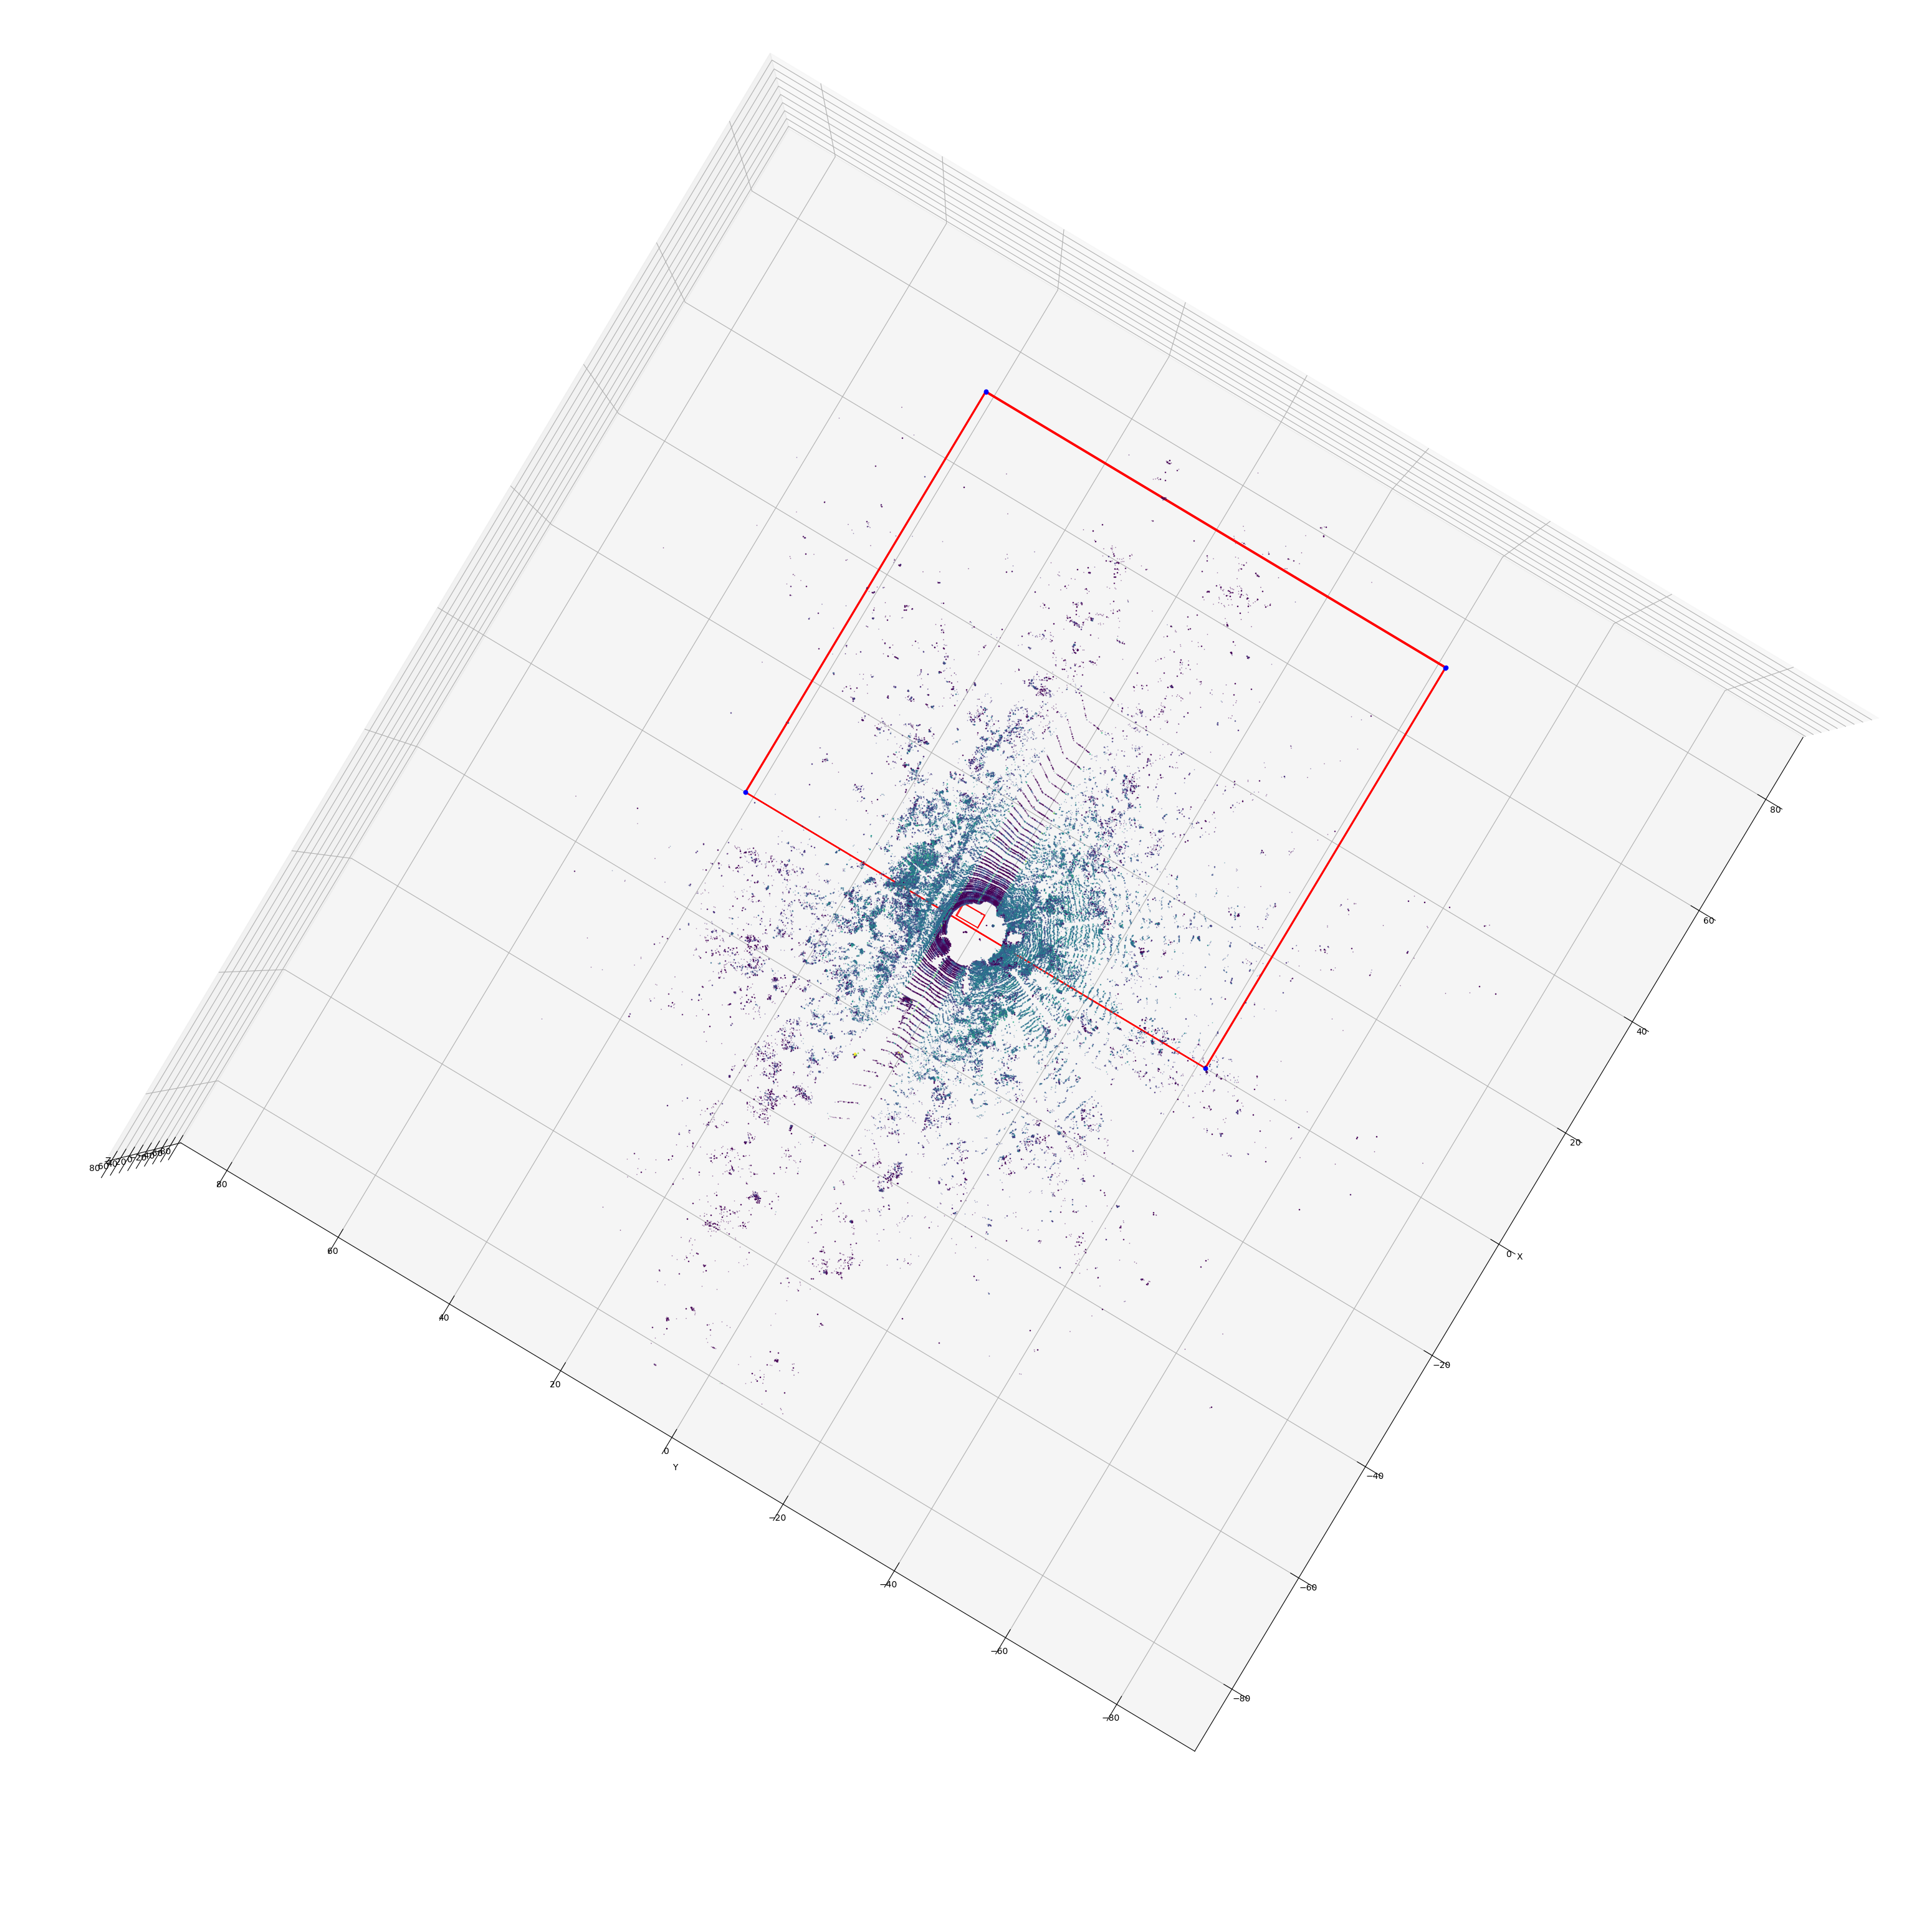

In [221]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_4[:, 0], points_4[:, 1], points_4[:, 2], s=0.1, c=points_4[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box only if the score is above the threshold
if show_bbox:
    for bbox in read_kitti_labels(labels_4):
        plot_bbox(ax, bbox)

# Define the point cloud range
x_range = [0, 69.12]
y_range = [-39.68, 39.68]
z_range = [-3, 1]

# Plotting the corners of the cuboid
for x in x_range:
    for y in y_range:
        for z in z_range:
            ax.scatter(x, y, z, color='b')

# Connect the points to form the edges of the cuboid
for x in x_range:
    ax.plot([x, x], y_range, [z_range[0], z_range[0]], 'r')
    ax.plot([x, x], y_range, [z_range[1], z_range[1]], 'r')
    ax.plot([x, x], [y_range[0], y_range[0]], z_range, 'r')
    ax.plot([x, x], [y_range[1], y_range[1]], z_range, 'r')

for y in y_range:
    ax.plot(x_range, [y, y], [z_range[0], z_range[0]], 'r')
    ax.plot(x_range, [y, y], [z_range[1], z_range[1]], 'r')

for z in z_range:
    ax.plot(x_range, [y_range[0], y_range[0]], [z, z], 'r')
    ax.plot(x_range, [y_range[1], y_range[1]], [z, z], 'r')
    ax.plot([x_range[0], x_range[0]], y_range, [z, z], 'r')
    ax.plot([x_range[1], x_range[1]], y_range, [z, z], 'r')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

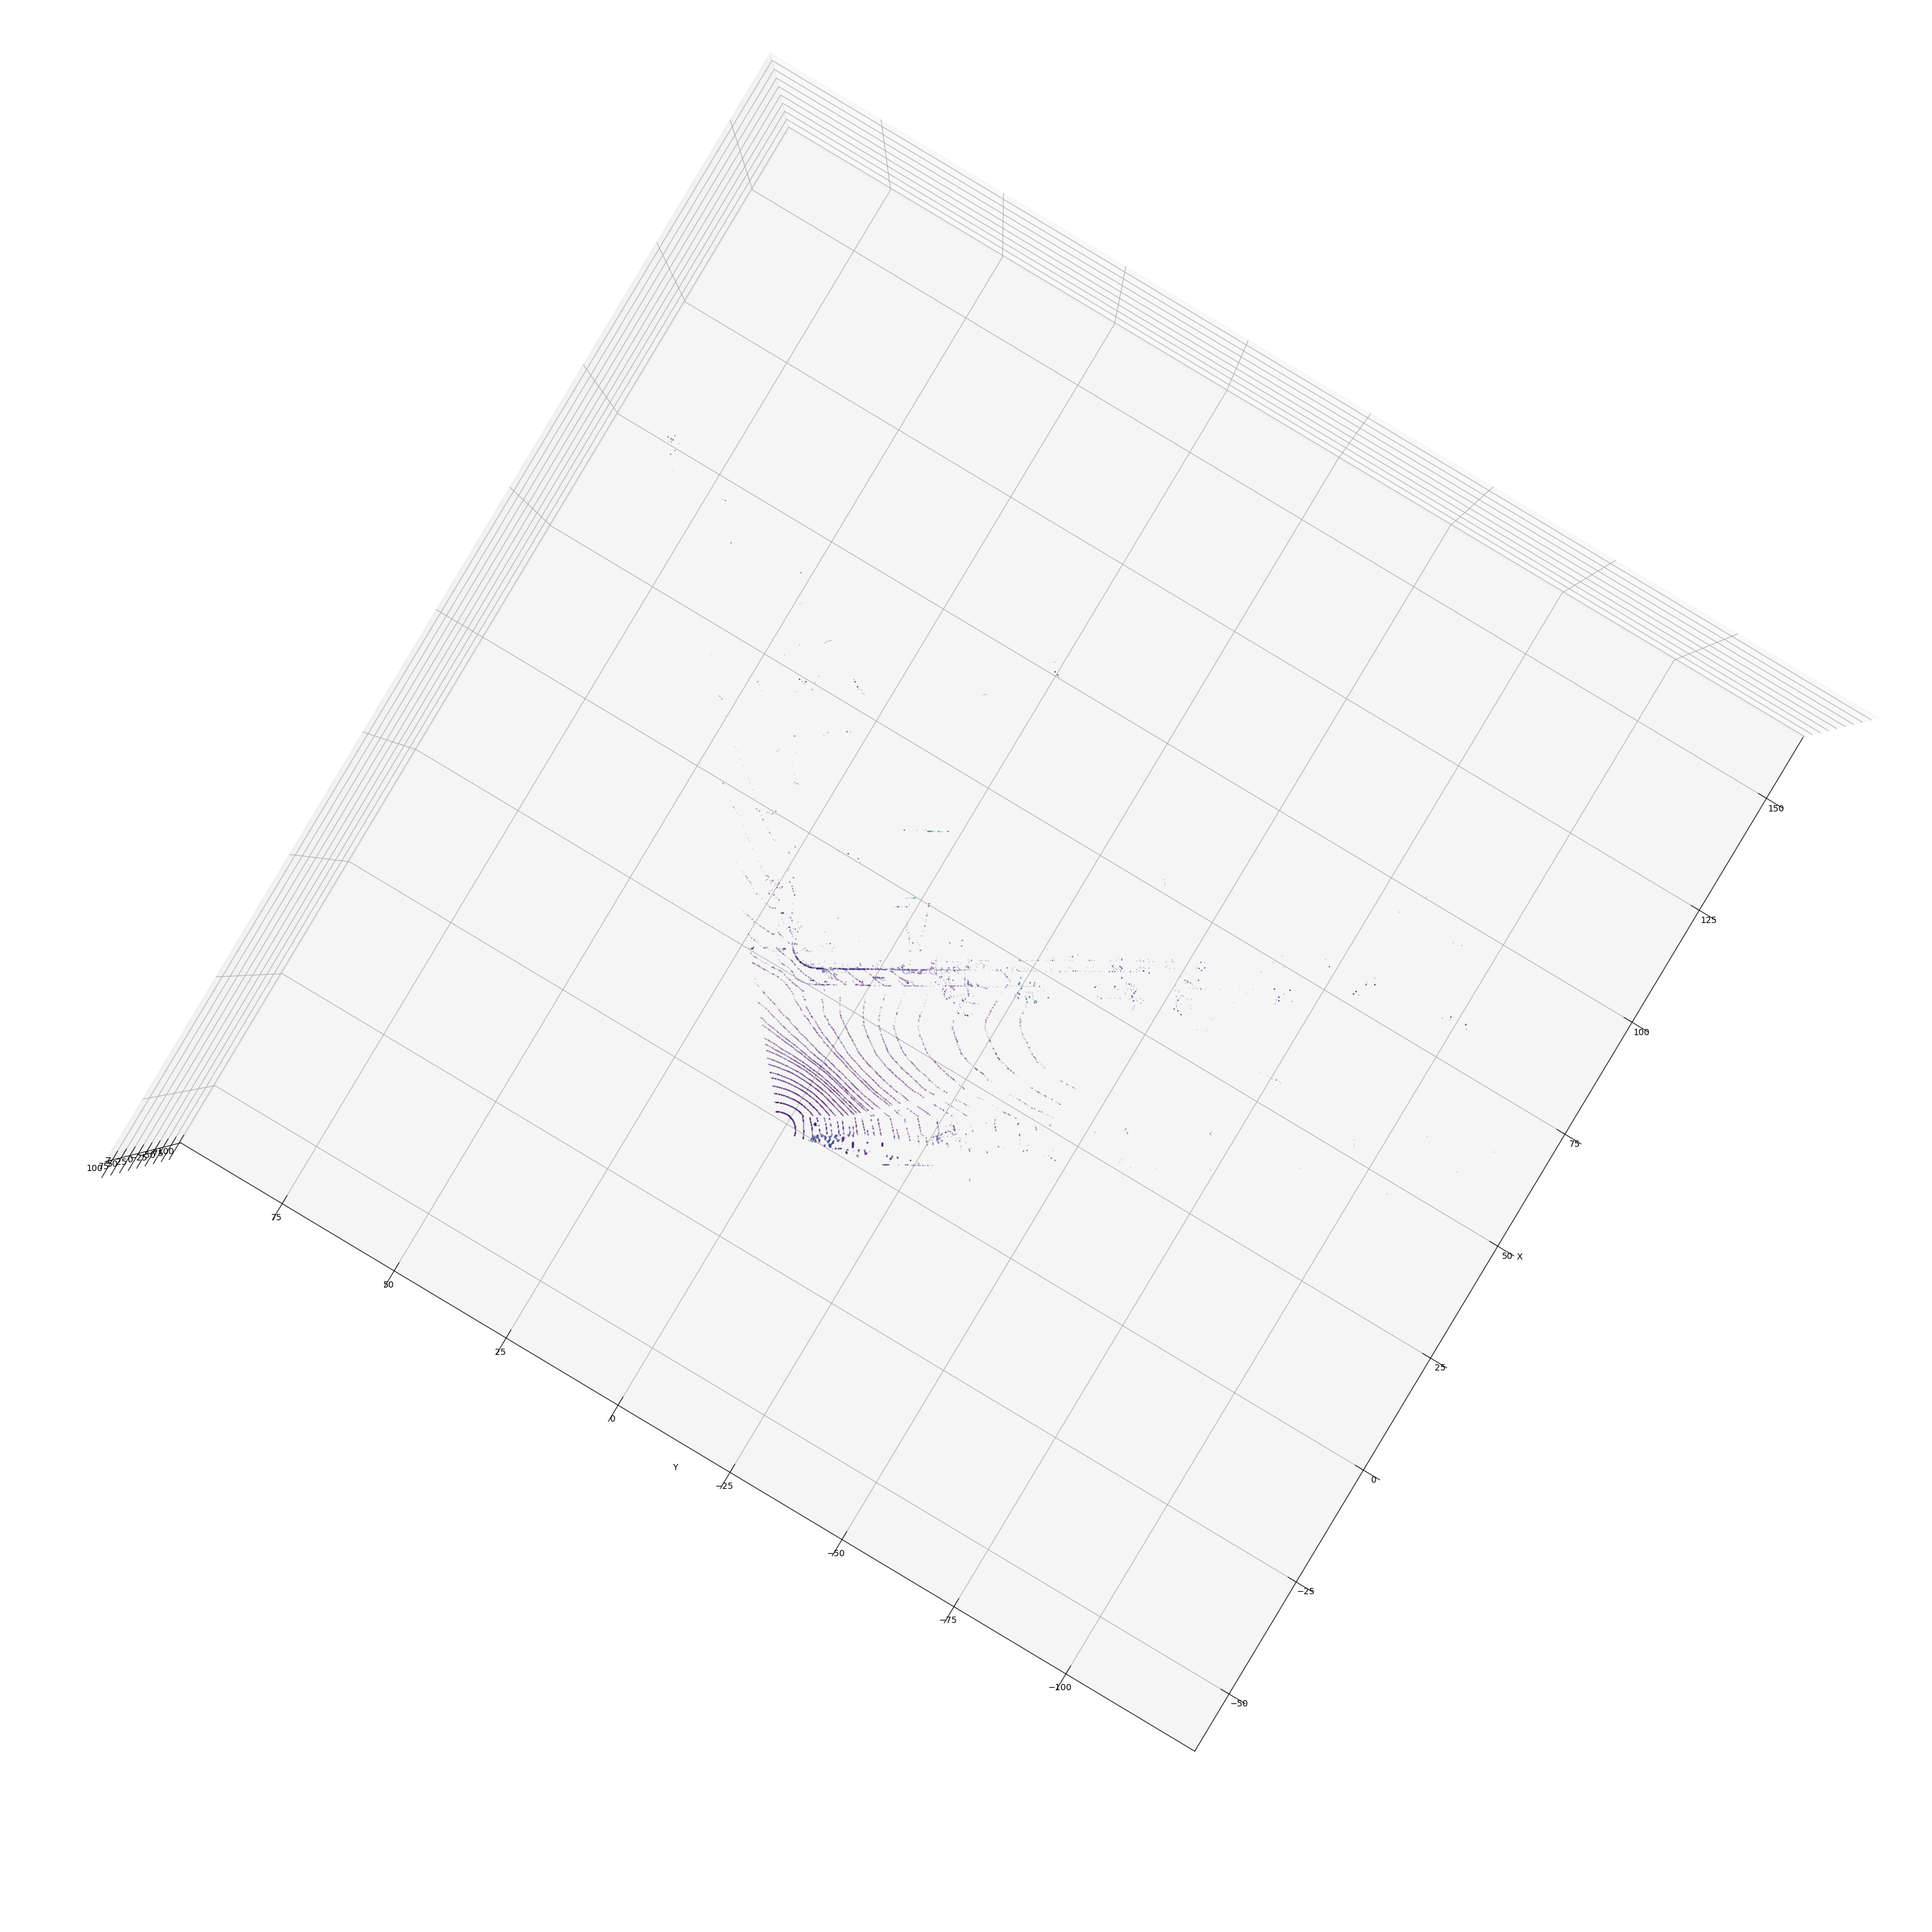

In [222]:
# LOOK AT REDUCED VELODYNE
reduced_bin = '..\\..\\000321.bin'
reduced_points = np.fromfile(reduced_bin, dtype=np.float32).reshape(-1, 4)
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(reduced_points[:, 0], reduced_points[:, 1], reduced_points[:, 2], s=0.1, c=reduced_points[:, 3], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()


# Save the figure
# fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

In [223]:
import ipywidgets as widgets
from IPython.display import display

In [224]:
# Update_plot function with a call to set_axes_equal
def update_plot(elev=30, azim=30):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()

    # Plot the point cloud
    ax.scatter(points_3[:, 0], points_3[:, 1], points_3[:, 2], s=0.01, c=points_3[:, 3], cmap='viridis', marker='.')
    
    score_threshold = 0.23
    
    # Plot each bounding box only if the score is above the threshold
    if show_bbox:
        for bbox in read_kitti_labels(labels_3):
            plot_bbox(ax, bbox)

    if show_label_area:
        plot_bbox(ax, label_area)

    # Setting the axes properties
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Adjust the view angle
    ax.view_init(elev=elev, azim=azim)

    # Fix aspect ratio
    set_axes_equal(ax)

    plt.show()

In [225]:
# Create sliders for elevation and azimuth
elev_slider = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevation')
azim_slider = widgets.IntSlider(min=0, max=360, step=1, value=30, description='Azimuth')

# Use interactive widgets to update the plot
widgets.interactive(update_plot, elev=elev_slider, azim=azim_slider)


interactive(children=(IntSlider(value=30, description='Elevation', max=90), IntSlider(value=30, description='A…